## Pipeline with breast cancer data of cBioPortal to check link between high proliferation/ Invasion and low Apoptosis with worse survival outcome

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import maboss
import gseapy as gp
from scipy.stats import spearmanr
import pandas as pd
import os
from pathlib import Path

from functions.validation_utils.validation_Breast import (
    process_montagud_nodes,process_montagud_nodes_synonyms, process_genes, pre_process_mutations, preprocess_cnv,create_generic_patients_cfgs_bnds, personalized_patients_genes_cfgs, generic_models_update_phenotypes, tailor_bnd_cnv_cm, correlate_boolean_predictions_with_gene_signatures, compute_phenotype_table, combine_patient_results, survival_analysis_comparison
)


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data

### Loading the dataset

In [2]:
#  somatic mutations, copy number alterations, and gene expression
# 2509 models


# genes_data = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt', sep='\t')

# try with raw data
genes_data = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray.txt',sep='\t')

mutations_data = pd.read_csv('data/cBioPortal/data_mutations.txt', sep='\t', skiprows=1)
cnv_data = pd.read_csv('data/cBioPortal/data_cna.txt', sep='\t')
clinical_patients_data = pd.read_csv('data/cBioPortal/data_clinical_patient.txt', sep='\t',skiprows=4)
clinical_samples = pd.read_csv('data/cBioPortal/data_clinical_sample.txt',sep='\t',skiprows=4)
nodes_montagud_synonyms = pd.read_csv('data/fumia_models/nodes_processed.txt',sep='\t')


montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])




onco_tsg_data = pd.read_csv('data/oncogenes_tsg.tsv',sep='\t')



In [3]:
clinical_patients_data_test = clinical_patients_data[clinical_patients_data['NPI'].notna()]
clinical_patients_data_test = clinical_patients_data_test[['PATIENT_ID', 'NPI', 'OS_MONTHS', 'OS_STATUS']]
clinical_patients_data_test = clinical_patients_data_test[clinical_patients_data_test['OS_MONTHS'].notna() & clinical_patients_data_test['OS_STATUS'].notna()]

# Sort by NPI
clinical_sorted = clinical_patients_data_test.sort_values('NPI')

# Select 50 lowest NPI (best prognosis)
low_npi_patients = clinical_sorted.head(100)['PATIENT_ID'].tolist()

# Select 50 highest NPI (worst prognosis)  
high_npi_patients = clinical_sorted.tail(100)['PATIENT_ID'].tolist()


patients_ids = low_npi_patients + high_npi_patients


print(len(patients_ids))

200


In [4]:
# try with more distinct groups 

In [5]:

discrete_variable = 'cnv_mutations'

continuous_variable = 'genes'


type_personalization = f'{discrete_variable}_{continuous_variable}'

folder = f'validation_Breast_{type_personalization}'

folder_generic_models = f"analysis/{folder}/models/generic/"
folder_models = f"analysis/{folder}/models"

if not os.path.exists(f"analysis/{folder}/results"):
    os.makedirs(f"analysis/{folder}/results")

if not os.path.exists(f"analysis/{folder}/models/personalized"):
    os.makedirs(f"analysis/{folder}/models/personalized")

dest_dir = f"analysis/{folder}/models/generic"
os.makedirs(dest_dir, exist_ok=True)



shutil.copy('data/fumia_models/Fumia2013.bnd', dest_dir)
shutil.copy('data/fumia_models/Fumia2013.cfg', dest_dir) 

'analysis/validation_Breast_cnv_mutations_genes/models/generic/Fumia2013.cfg'

In [6]:
folder_models = f'analysis/validation_Breast_{type_personalization}/models/personalized'
results_folder = f'analysis/validation_Breast_{type_personalization}/results'


Get patients IDs (Try random group of patients)

In [7]:

# nb_patients = 100
phenotype_interest = ["Proliferation","Apoptosis"]
inputs_list = ['GLI', 'MAX', 'PTEN', 'Acidosis', 'p14ARF', 'ROS', 'Hypoxia', 'Nutrients', 'Carcinogen', 'GFs', 'TNFalpha']



# patients_ids_clinical = list(set(clinical_patients_data['PATIENT_ID']))
# patients_ids_mutations = list(set(mutations_data['Tumor_Sample_Barcode']))
# patients_ids_genes = list(set(genes_data.columns[2:]))
# patients_ids_cnv = list(set(cnv_data.columns[2:]))

# common_patients = list(set(patients_ids_clinical) & set(patients_ids_mutations) & set(patients_ids_genes) & set(patients_ids_cnv))

# common_patients.sort()

# patients_ids = [patient for patient in common_patients if patient.startswith('MB')][:nb_patients]

Filtering/ Preprocessing datasets

In [8]:
# Keep Hugo_Symbol, Entrez_Gene_Id, and patient columns
cnv_data_filtered = cnv_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                             [col for col in cnv_data.columns if col in patients_ids]]
genes_data_filtered = genes_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                             [col for col in genes_data.columns if col in patients_ids]]

mutations_data_filtered = mutations_data[mutations_data['Tumor_Sample_Barcode'].isin(patients_ids)]

clinical_patients_data_filtered = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]

In [9]:
montagud_node_synonyms, synonyms_to_nodes_dict = process_montagud_nodes_synonyms(nodes_montagud_synonyms)
montagud_node_model, all_montagud_nodes = process_montagud_nodes(
    montagud_original_data_df, montagud_node_synonyms)

In [10]:
rna_seq_data_final = process_genes(patients_ids, genes_data_filtered, all_montagud_nodes, synonyms_to_nodes_dict)

 Duplicated MTOR: mTORC1 (1 rows) + mTORC2 (1 rows)
 Duplicated MYC: MYC (1 rows) + MYC_MAX (1 rows)
 Duplicated PIK3CA: PI3K (1 rows) + PIP3 (1 rows)
 Duplicated LDHA: LDHA (1 rows) + Lactic_acid (1 rows)
 Duplicated ERG: AR_ERG (1 rows) + ERG (1 rows)


/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_Breast.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data_filtered['Hugo_Symbol'] = rna_seq_data_filtered['Hugo_Symbol'].str.strip()


In [11]:
cnv_data_filt = preprocess_cnv(patients_ids, cnv_data, all_montagud_nodes, synonyms_to_nodes_dict)

In [12]:
mutations_data_filtered =  pre_process_mutations(patients_ids, mutations_data, onco_tsg_data, all_montagud_nodes, synonyms_to_nodes_dict)


## Create personalized boolean networks (genes and CNV)

In [13]:
create_generic_patients_cfgs_bnds(
    folder_generic_models,
    folder_models,
    patients_ids,
)

Created files for patient MB-0281
Created files for patient MB-0284
Created files for patient MB-0351
Created files for patient MB-0333
Created files for patient MB-0876
Created files for patient MB-5186
Created files for patient MB-7217
Created files for patient MB-0472
Created files for patient MB-4839
Created files for patient MB-0260
Created files for patient MB-0245
Created files for patient MB-5174
Created files for patient MB-2821
Created files for patient MB-4681
Created files for patient MB-0318
Created files for patient MB-4145
Created files for patient MB-5278
Created files for patient MB-0539
Created files for patient MB-7249
Created files for patient MB-0160
Created files for patient MB-3797
Created files for patient MB-5435
Created files for patient MB-5110
Created files for patient MB-7041
Created files for patient MB-0299
Created files for patient MB-7188
Created files for patient MB-6011
Created files for patient MB-0263
Created files for patient MB-0153
Created files 

In [14]:
generic_models_update_phenotypes(phenotype_interest, folder_models)

Updated Proliferation.is_internal=FALSE in MB-5186.cfg
Updated Apoptosis.is_internal=FALSE in MB-5186.cfg
Modified and saved: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-5186.cfg
Updated Proliferation.is_internal=FALSE in MB-4529.cfg
Updated Apoptosis.is_internal=FALSE in MB-4529.cfg
Modified and saved: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-4529.cfg
Updated Proliferation.is_internal=FALSE in MB-5435.cfg
Updated Apoptosis.is_internal=FALSE in MB-5435.cfg
Modified and saved: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-5435.cfg
Updated Proliferation.is_internal=FALSE in MB-3865.cfg
Updated Apoptosis.is_internal=FALSE in MB-3865.cfg
Modified and saved: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-3865.cfg
Updated Proliferation.is_internal=FALSE in MB-3497.cfg
Updated Apoptosis.is_internal=FALSE in MB-3497.cfg
Modified and saved: analysis/validation_Breast_cnv_mutations_genes/models/

In [15]:
# Tailor the networks accoring to the discrete variable

if discrete_variable == 'mutations':
    tailor_bnd_cnv_cm(mutations_data_filtered, folder_models)
    print('mutations selected')

elif discrete_variable == 'cnv':
    tailor_bnd_cnv_cm(cnv_data_filt, folder_models)
    print('cnv selected')
elif discrete_variable == 'cnv_mutations':
    tailor_bnd_cnv_cm(cnv_data_filt, folder_models)
    tailor_bnd_cnv_cm(mutations_data_filtered, folder_models)
    print('mutations and cnv selected')

else:
    print('select between mutations or cnv or cnv_mutations')

🔍 Processing patient MB-3497, gene: CyclinE
CyclinE node found. Replacing...
🔍 Processing patient MB-3497, gene: E2F
E2F node found. Replacing...
🔍 Processing patient MB-3497, gene: RTK
RTK node found. Replacing...
🔍 Processing patient MB-3497, gene: p70S6kab
p70S6kab node found. Replacing...
🔍 Processing patient MB-3497, gene: SPOP
No SPOP node found in file for patient MB-3497
🔍 Processing patient MB-3497, gene: TERT
TERT node found. Replacing...
🔍 Processing patient MB-3497, gene: YWHAZ
No YWHAZ node found in file for patient MB-3497
MB-3497: CNV — nodes modified
🔍 Processing patient MB-0020, gene: Smad2_3_Smad4
Smad2_3_Smad4 node found. Replacing...
MB-0020: CNV — nodes modified
🔍 Processing patient MB-5294, gene: Smad2_3_Smad4
Smad2_3_Smad4 node found. Replacing...
MB-5294: CNV — nodes modified
🔍 Processing patient MB-6229, gene: RTK
RTK node found. Replacing...
MB-6229: CNV — nodes modified
🔍 Processing patient MB-0368, gene: FADD
FADD node found. Replacing...
🔍 Processing patien

In [16]:
personalized_patients_genes_cfgs(
    rna_seq_data_final,
    all_montagud_nodes,
    folder_models,
    amplif_factor = 100,
)

==== Processing all genes per patient ===

Processing file: MB-5186.cfg
  No data for CDH1
  No data for WNT1
  No data for SMAD2
  No data for CCNB1
  No data for MTOR
  No data for CDC20
  No data for DVL3
  No data for DVL1
  No data for ARAF
  No data for CDKN1B
  No data for TGFB1
  No data for VEGFD
  No data for NFKB1
  No data for GLI2
  No data for BAK1
  No data for CASP9
  No data for CCND3
  No data for CDKN2A
  No data for TSC2
  No data for MAP3K7
  No data for TP53
  No data for CCND1
  No data for INSR
  No data for EGLN2
  No data for VEGFC
  No data for RB1
  No data for NRAS
  No data for CASP8
  No data for E2F4
  No data for FOXO1
  No data for VEGFA
  No data for CDKN1A
  No data for nan
  No data for CCNB3
  No data for E2F5
  No data for PIK3CA
  No data for PRKCA
  No data for ADCY1
  No data for RAF1
  No data for ERBB3
  No data for SMAD3
  No data for BCL2L1
  No data for TNFRSF1A
  No data for EEF2K
  No data for ERBB4
  No data for NOX1
  No data for EEF2


KeyboardInterrupt: 

## MaBoSS simulation

In [ ]:
for patient in patients_ids:
    results_maboss = compute_phenotype_table(
        results_folder,
        folder_models,
        patient,
        inputs_list,
        phenotype_interest,
    )

Processing patient: 'MB-0281'
Looking for files:
  BND: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0281.bnd
  CFG: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0281.cfg
  BND exists: True
  CFG exists: True
Processing patient: 'MB-0284'
Looking for files:
  BND: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0284.bnd
  CFG: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0284.cfg
  BND exists: True
  CFG exists: True
Processing patient: 'MB-0351'
Looking for files:
  BND: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0351.bnd
  CFG: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0351.cfg
  BND exists: True
  CFG exists: True
Processing patient: 'MB-0333'
Looking for files:
  BND: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0333.bnd
  CFG: analysis/validation_Breast_cnv_mutations_genes/models/personalized/MB-0333.cfg
  

In [ ]:
# Use the function
combined_results = combine_patient_results(results_folder)

## Survival analysis


In [ ]:
# Create groups based on proliferation level and then apoptosis level
combined_results_survival = combined_results.copy()
combined_results_survival['Group_Proliferation'] = np.where(
    combined_results_survival['Proliferation'] < combined_results['Proliferation'].mean(), 
    'low', 
    'high'
)

# You can also create groups for Apoptosis
combined_results_survival['Group_Apoptosis'] = np.where(
    combined_results_survival['Apoptosis'] < combined_results['Apoptosis'].mean(), 
    'low', 
    'high'
)

In [ ]:
# Processing survival data

survival_columns = [
    'PATIENT_ID',           # Patient identifier
    'OS_MONTHS',            # Overall survival time (months)
    'OS_STATUS',            # Overall survival status (0=alive, 1=dead)
]

clinical_patients_data_filtered = clinical_patients_data_filtered[survival_columns]
clinical_patients_ids = list(set(clinical_patients_data_filtered['PATIENT_ID']))

combined_results = combined_results.reset_index()
patients_ids_phenotype_data = list(set(combined_results['patient_id']))

# merge the two 
# Same as above but using the dataframe method
survival_analysis_data = clinical_patients_data_filtered.merge(
    combined_results, 
    left_on='PATIENT_ID', 
    right_on='patient_id', 
    how='inner'
)


survival_analysis_data['OS_STATUS'] = survival_analysis_data['OS_STATUS'].map({
        '0:LIVING': 0,
        '1:DECEASED': 1,
        'LIVING': 0,
        'DECEASED': 1,
        0: 0,
        1: 1
    })


survival_analysis_data['Group_Proliferation'] = np.where(
    survival_analysis_data['Proliferation'] < survival_analysis_data['Proliferation'].median(), 
    'low', 
    'high'
)

# You can also create groups for Apoptosis using median
survival_analysis_data['Group_Apoptosis'] = np.where(
    survival_analysis_data['Apoptosis'] < survival_analysis_data['Apoptosis'].median(), 
    'low', 
    'high'
)



In [ ]:
type_personalization

'cnv_mutations_genes'

Group 'low': 100 patients
Group 'high': 100 patients

Log-rank test:
Test statistic: 7.6830
p-value: 0.0056
Significant difference (α=0.05): True

Plot saved to: analysis/validation_Breast_cnv_mutations_genes/results/outputs/survival_analysis_group-proliferation.png


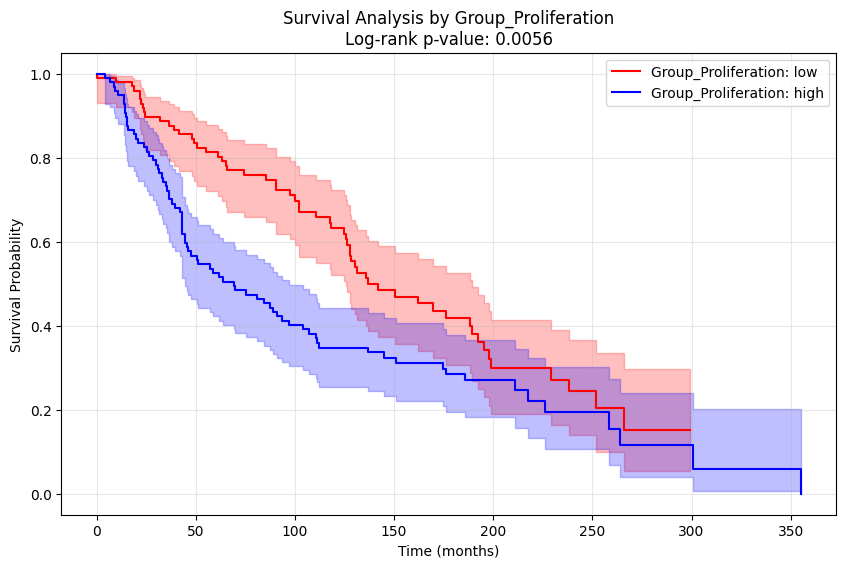

Group 'high': 100 patients
Group 'low': 100 patients

Log-rank test:
Test statistic: 0.0189
p-value: 0.8907
Significant difference (α=0.05): False

Plot saved to: analysis/validation_Breast_cnv_mutations_genes/results/outputs/survival_analysis_group-apoptosis.png


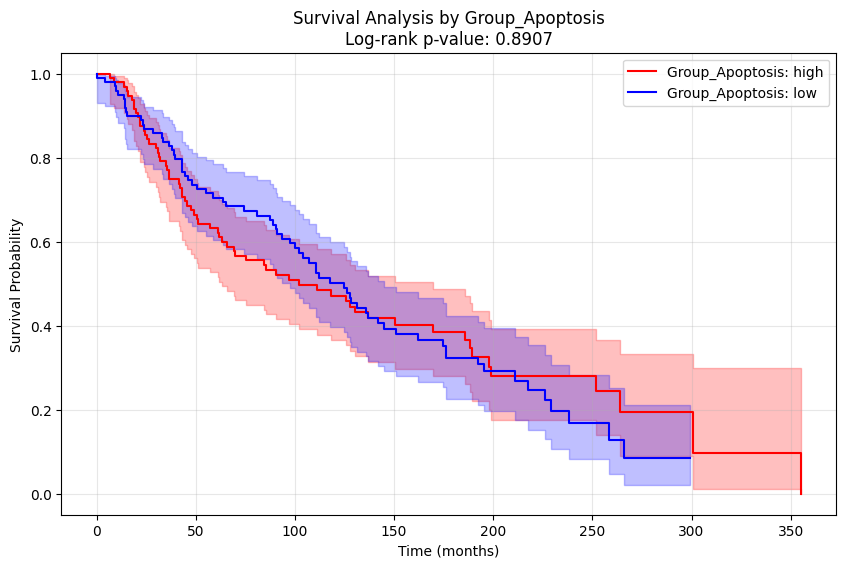

In [ ]:
# Use the updated function
results_prolif = survival_analysis_comparison(
    survival_analysis_data, 
    'Group_Proliferation', 
    pers_technique=type_personalization,
    save_plots=True
)

results_apopto = survival_analysis_comparison(
    survival_analysis_data, 
    'Group_Apoptosis',
    pers_technique=type_personalization,
    save_plots=True
)


## Gene signature correlation

In [ ]:
def combine_patient_results(results_folder):
    """
    Combine individual patient CSV files into one dataframe
    Rows: patient IDs
    Columns: input_phenotype combinations (e.g., 'GLI_Proliferation', 'GLI_Apoptosis')
    """
    all_data = []
    
    # Get all CSV files in the results folder
    csv_files = [f for f in os.listdir(results_folder) if f.endswith('.csv')]
    
    for csv_file in csv_files:
        # Extract patient ID from filename (remove .csv extension)
        patient_id = Path(csv_file).stem
        
        # Read the CSV file
        df = pd.read_csv(os.path.join(results_folder, csv_file), index_col=0)
        
        # Create flattened data for this patient
        patient_data = {'patient_id': patient_id}
        
        # Iterate through each input (row in CSV)
        for input_name in df.index:
            # Iterate through each phenotype (column in CSV)
            for phenotype in df.columns:
                # Create combined column name: input_phenotype
                column_name = f"{input_name}_{phenotype}"
                patient_data[column_name] = df.loc[input_name, phenotype]
        
        all_data.append(patient_data)
    
    # Create combined dataframe
    combined_df = pd.DataFrame(all_data)
    combined_df.set_index('patient_id', inplace=True)
    
    return combined_df

In [ ]:
# combined all the data 
combined_df = combine_patient_results(results_folder)
combined_df.index.name = None

In [ ]:
hallmark = 'G2-M Checkpoint'
phenotype = 'Proliferation'

genes_data_melted = pd.melt(
    genes_data,
    id_vars=['Hugo_Symbol', 'Entrez_Gene_Id'],  # Keep these columns as identifiers
    var_name='model_id',                        # Column names become 'model_id'
    value_name='expression_value'               # Values become 'expression_value'
)

genes_data_melted = genes_data_melted.rename(columns={'Hugo_Symbol': 'gene_symbol', 'expression_value': 'rsem_tpm'})
genes_data_melted = genes_data_melted.drop('Entrez_Gene_Id', axis=1)


In [1]:
results_corr_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(combined_df, hallmark, phenotype, genes_data_melted, patients_ids)
results_corr_df.loc['Mean'] = results_corr_df.mean()

# Create the outputs directory if it doesn't exist
os.makedirs(f'{results_folder}/outputs', exist_ok=True)

results_folder_output = f'{results_folder}/outputs/results_genes_signature_correlation.csv'
results_corr_df.to_csv(results_folder_output)

NameError: name 'correlate_boolean_predictions_with_gene_signatures' is not defined

## Correlation to the NPI values

In [ ]:
clinical_patients_data_NPI = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]
clinical_patients_data_NPI = clinical_patients_data_NPI[['PATIENT_ID', 'NPI']]

clinical_patients_data_NPI = clinical_patients_data_NPI.merge(
    combined_results, 
    left_on='PATIENT_ID', 
    right_on='patient_id'
)

phenotypes_list = ['Proliferation', 'Apoptosis']
corr_NPI_results_df = pd.DataFrame(index=phenotypes_list, columns = ['Correlation', 'P-value'])

for phenotype in phenotypes_list:
    corr, pval = spearmanr(list(clinical_patients_data_NPI['NPI']), list(clinical_patients_data_NPI[phenotype]))
    corr_NPI_results_df.loc[phenotype, 'Correlation'] = corr
    corr_NPI_results_df.loc[phenotype, 'P-value'] = pval



results_folder_output = f'{results_folder}/outputs/NPI_correlation.csv'
corr_NPI_results_df.to_csv(results_folder_output)


In [ ]:
# compute correlation between NPI and probability 


# inactivating mutations (nonsense, frame-shift insertions or deletions and mutation in splice or translation start sites)



# === Assumption ===
# mutations targeting oncogenes -> gain of function
# mutations targeting Tumor suppressor genes -> loss of function


# SIFT and  PolyPhen scores



In [ ]:
cnv_genes_results = pd.read_csv('analysis/validation_Breast_cnv_genes/results/outputs/results_genes_signature_correlation.csv')


In [ ]:
cnv_genes_results

,Unnamed: 0,correlation_value,p_val
0,GLI_Proliferation,0.634992,5.663806e-24
1,MAX_Proliferation,0.664298,7.930346e-27
2,PTEN_Proliferation,0.651253,1.616187e-25
3,Acidosis_Proliferation,0.663702,9.132461e-27
4,p14ARF_Proliferation,0.649679,2.302357e-25
5,ROS_Proliferation,0.653998,8.677817e-26
6,Hypoxia_Proliferation,0.651425,1.554750e-25
7,Nutrients_Proliferation,0.639292,2.257895e-24
8,Carcinogen_Proliferation,0.645486,5.847840e-25
9,GFs_Proliferation,0.658870,2.830987e-26


In [ ]:
cnv_genes_results['p_val'].iloc[:-1].mean()

np.float64(8.64639800659577e-25)

In [ ]:
mutations_genes_results

,Unnamed: 0.1,Unnamed: 0,correlation_value,p_val
0,0,GLI_Proliferation,0.648729,2.846945e-25
1,1,MAX_Proliferation,0.682768,8.493273e-29
2,2,PTEN_Proliferation,0.684603,5.313252e-29
3,3,Acidosis_Proliferation,0.700047,8.903975e-31
4,4,p14ARF_Proliferation,0.681760,1.097275e-28
5,5,ROS_Proliferation,0.690752,1.075800e-29
6,6,Hypoxia_Proliferation,0.694483,4.002389e-30
7,7,Nutrients_Proliferation,0.673223,9.225887e-28
8,8,Carcinogen_Proliferation,0.686058,3.653782e-29
9,9,GFs_Proliferation,0.684594,5.325913e-29


In [ ]:
mean_value = mutations_genes_results['p_val'].iloc[:-1].mean()
print(mean_value)

2.617000036035937e-26


In [ ]:
csv_genes_results = csv_genes_results.set_index(csv_genes_results.columns[0])
csv_genes_results.index.name = None
csv_genes_results.loc['Mean'] = csv_genes_results.mean()

csv_genes_results.to_csv('analysis/validation_Breast_cnv_genes/results/outputs/results_genes_signature_correlation.csv')

In [ ]:
csv_genes_results.loc['Mean'] = csv_genes_results.mean()


In [ ]:
csv_genes_results

,correlation_value,p_val
GLI_Proliferation,0.634992,5.663806e-24
MAX_Proliferation,0.664298,7.930346e-27
PTEN_Proliferation,0.651253,1.616187e-25
Acidosis_Proliferation,0.663702,9.132461e-27
p14ARF_Proliferation,0.649679,2.302357e-25
ROS_Proliferation,0.653998,8.677817e-26
Hypoxia_Proliferation,0.651425,1.554750e-25
Nutrients_Proliferation,0.639292,2.257895e-24
Carcinogen_Proliferation,0.645486,5.847840e-25
GFs_Proliferation,0.658870,2.830987e-26
